In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [2]:
dataset_path = "Multi-class Weather Dataset"
image_size = (180, 180)
batch_size = 32
seed = 1337

val_ds = keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size
)

class_names = val_ds.class_names
num_classes = len(class_names)

# prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 1083 files belonging to 4 classes.
Using 216 files for validation.


In [3]:
model_baseline = keras.models.load_model("TransferWeatherModel.keras")
model_augmented = keras.models.load_model("BaselineModelWithAugmentation.keras")

In [6]:
y_true = []
y_pred_base = []
y_pred_aug = []

for images, labels in val_ds:
    y_true.extend(labels.numpy())
    y_pred_base.extend(model_baseline.predict(images))
    y_pred_aug.extend(model_augmented.predict(images))

# convert to np arrays
y_true = np.array(y_true)
y_pred_base = np.array(y_pred_base)
y_pred_aug = np.array(y_pred_aug)

# one-hot encode true labels for ROC
y_true_bin = label_binarize(y_true, classes=range(num_classes))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


2025-08-04 15:39:18.901160: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


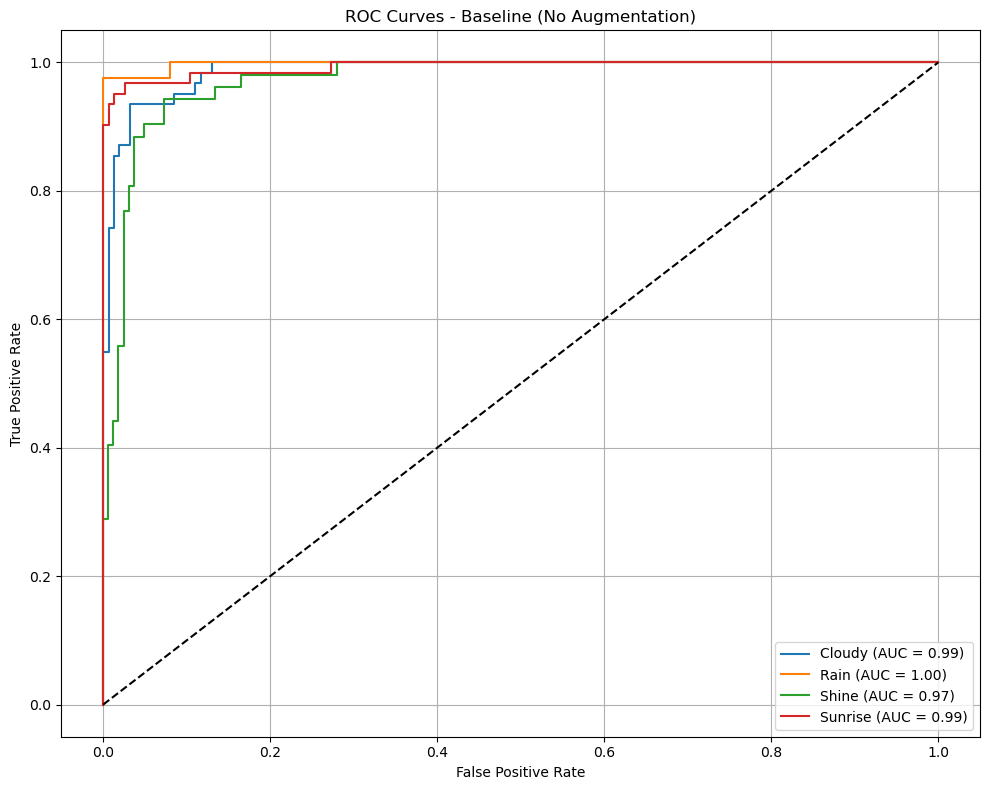

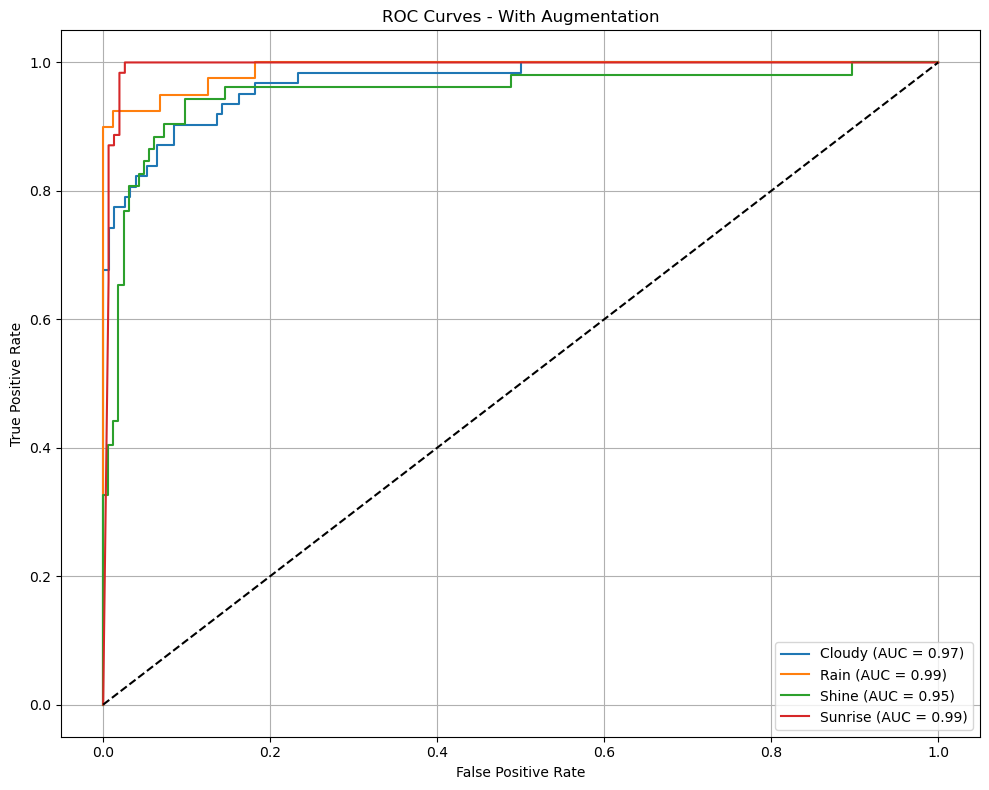

In [7]:
from sklearn.metrics import RocCurveDisplay

def plot_roc_curves(y_true_bin, y_scores, model_name):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i],
                 label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves - {model_name}")
    plt.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    plt.show()

# plot both models
plot_roc_curves(y_true_bin, y_pred_base, "Baseline (No Augmentation)")
plot_roc_curves(y_true_bin, y_pred_aug, "With Augmentation")